# Measuring the effectiveness of trainable quantum neural networks

To find out which of our designed circuits has any real, reproducable value, we will run each of them various times to see how they perform

In [34]:
#imports
import csv

import numpy as np
import matplotlib.pyplot as plt

from qiskit import Aer, QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_state_qsphere
from qiskit.opflow import Z, I, StateFn
from qiskit.utils import QuantumInstance
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.algorithms.optimizers import *
import qiskit.quantum_info as qi

from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from typing import Union

from qiskit_machine_learning.exceptions import QiskitMachineLearningError

from IPython.display import clear_output

import warnings
warnings.simplefilter('ignore')

import random
import time

random.seed(69069)
np.random.seed(69069)

In [32]:
#create folder for figures
import os
path = '../figures/hearth_failure/non_randomized_split/'
training_measurments_path = '../training_measurments/hearth_failure/non_randomized_split/'
try:
    os.makedirs(path)
except:
    print('path already exists!')

try:
    os.makedirs(training_measurments_path)
except:
    print('path already exists!')

path already exists!


In [49]:
def plot_boxplots(run, title, circuit_index, save=False):
    min = np.amin(run)-0.01
    max = np.amax(run)+0.01
    fig = plt.figure()
    gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
    (ax1, ax2) = gs.subplots(sharex='col', sharey='row')
    ax1.set_ylim([min,max])
    ax2.set_ylim([min,max])
    fig.suptitle(title)
    ax1.set_title('Training')
    ax1.boxplot(run[0], showfliers=True, sym='k.')
    ax2.set_title('Testing')
    ax2.boxplot(run[1], showfliers=True, sym='k.')
    if(save):
        plt.savefig(path+title.replace(" ", "_")+'.svg', format="svg", transparent=True)
    display(plt.show())

In [2]:
#code to normalize features to a range of -1 and 1
from sklearn.preprocessing import MinMaxScaler

def normalize_data(data):
    return MinMaxScaler().fit_transform(data) * 2 - 1

#code to normalize features to a range of -pi and pi
def pifi_data(data):
    return MinMaxScaler().fit_transform(data) * 2 * np.pi - np.pi

#code to leave features as is
def as_is(data):
    return data


## IRIS tests
We will now create the circuits needed for the IRIS tests

In [28]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

#Arrays
circuits = []
datasets = []
accuracy = []

n_shots = 1024
#Data
heart_data = pd.read_csv('monteric/data/heart_failure_clinical_records_dataset.csv')

# only the features used in the notebook
Features = ['time','ejection_fraction','serum_creatinine']
data = heart_data[Features]
targets = heart_data["DEATH_EVENT"]

simulator_gpu = Aer.get_backend('aer_simulator')
simulator_gpu.set_options(device='GPU')
quantum_instance = QuantumInstance(simulator_gpu, shots=n_shots)

datasets.append(data)
datasets.append(normalize_data(data))
datasets.append(pifi_data(data))

n_features = 3

output_shape = 2
def parity(x):
    return '{:b}'.format(x).count('1') % 2

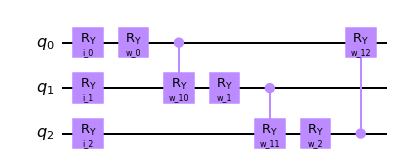

In [4]:
feature_map = QuantumCircuit(3)
ansatz = QuantumCircuit(3)
for i in range(n_features):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%3)


qc = QuantumCircuit(3)
qc.append(feature_map, range(3))
qc.append(ansatz, range(3))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

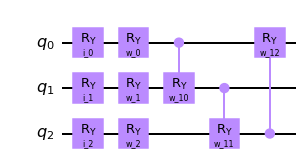

In [5]:
feature_map = QuantumCircuit(3)
ansatz = QuantumCircuit(3)
for i in range(3):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)

for i in range(3):
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%3)


qc = QuantumCircuit(3)
qc.append(feature_map, range(3))
qc.append(ansatz, range(3))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

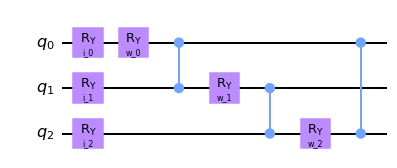

In [6]:
feature_map = QuantumCircuit(3)
ansatz = QuantumCircuit(3)
for i in range(3):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%3)


qc = QuantumCircuit(3)
qc.append(feature_map, range(3))
qc.append(ansatz, range(3))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

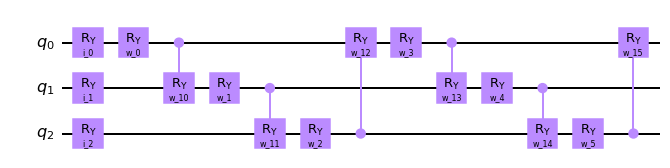

In [7]:
feature_map = QuantumCircuit(3)
ansatz = QuantumCircuit(3)
for i in range(3):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%3)


for i in range(3):
    ansatz.ry(Parameter('w_' + str(i+3)),i)
    ansatz.cry(Parameter('w_' + str(10+i+3)), i, (i+1)%3)

qc = QuantumCircuit(3)
qc.append(feature_map, range(3))
qc.append(ansatz, range(3))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

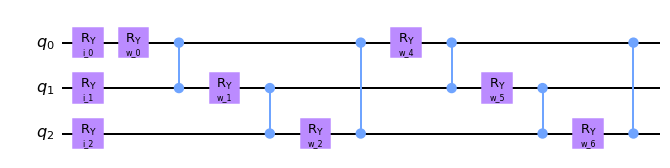

In [8]:
feature_map = QuantumCircuit(3)
ansatz = QuantumCircuit(3)
for i in range(3):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.ry(Parameter('w_' + str(i)),i)
    ansatz.cz(i, (i+1)%3)


for i in range(3):
    ansatz.ry(Parameter('w_' + str(i+4)),i)
    ansatz.cz(i, (i+1)%3)

qc = QuantumCircuit(3)
qc.append(feature_map, range(3))
qc.append(ansatz, range(3))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

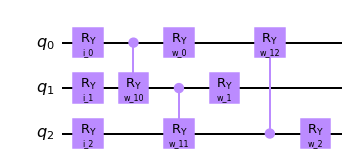

In [9]:
feature_map = QuantumCircuit(3)
ansatz = QuantumCircuit(3)
for i in range(3):
    feature_map.ry(Parameter('i_' + str(i)),i)
    ansatz.cry(Parameter('w_' + str(10+i)), i, (i+1)%3)
    ansatz.ry(Parameter('w_' + str(i)),i)


qc = QuantumCircuit(3)
qc.append(feature_map, range(3))
qc.append(ansatz, range(3))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

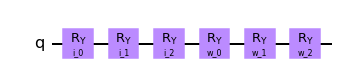

In [10]:
feature_map = QuantumCircuit(1)
ansatz = QuantumCircuit(1)
for i in range(3):
    feature_map.ry(Parameter('i_' + str(i)),0)
    ansatz.ry(Parameter('w_' + str(i)),0)


qc = QuantumCircuit(1)
qc.append(feature_map, range(1))
qc.append(ansatz, range(1))

circuits.append(qc.decompose().copy())
circuits[-1].draw('mpl')

### Functions needed for training

In [11]:
def fit_and_score(circuit_classifier, x_train, y_train, x_test, y_test):
    # fit classifier to data
    circuit_classifier.fit(x_train, y_train)
    score_train =  circuit_classifier.score(x_train, y_train)
    score_test =  circuit_classifier.score(x_test, y_test)
    print("Mean Accuracy training: " + str(score_train))
    print("Mean Accuracy testing: " + str(score_test))
    return score_train, score_test

def get_classifier(circuit):
    circuit_qnn = CircuitQNN(circuit=circuit,    
                         input_params=circuit.parameters[0:n_features],
                         weight_params=circuit.parameters[n_features:],
                         interpret=parity,
                         output_shape=output_shape,
                         quantum_instance=quantum_instance)

    # construct classifier
    return NeuralNetworkClassifier(neural_network=circuit_qnn,                                             
                                                optimizer=COBYLA())

In [12]:
#so
raw_runs = []

display(print("Testing dataset 1"))
for circuit in circuits:
    training_data = []
    testing_data = []
    for i in range(10):
        display(print('run: ' + str(i+1)))
        classifier = get_classifier(circuit.copy())
        x_train,x_test,y_train,y_test = train_test_split(datasets[0], targets, test_size=1-3/4, random_state=69069)
        score_train, score_test = fit_and_score(classifier, x_train.values, y_train.values, x_test.values, y_test.values)
        training_data.append(score_train)
        testing_data.append(score_test)
    display(print('Circuit done'))
    raw_runs.append([training_data, testing_data])

Testing dataset 1


None

run: 1


None

Mean Accuracy training: 0.6205357142857143
Mean Accuracy testing: 0.49333333333333335
run: 2


None

Mean Accuracy training: 0.53125
Mean Accuracy testing: 0.5466666666666666
run: 3


None

Mean Accuracy training: 0.6071428571428571
Mean Accuracy testing: 0.5733333333333334
run: 4


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.49333333333333335
run: 5


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.48
run: 6


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.49333333333333335
run: 7


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.5066666666666667
run: 8


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.49333333333333335
run: 9


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.5066666666666667
run: 10


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.48
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6294642857142857
Mean Accuracy testing: 0.49333333333333335
run: 2


None

Mean Accuracy training: 0.5491071428571429
Mean Accuracy testing: 0.6133333333333333
run: 3


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.5066666666666667
run: 4


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.5066666666666667
run: 5


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.49333333333333335
run: 6


None

Mean Accuracy training: 0.6294642857142857
Mean Accuracy testing: 0.48
run: 7


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.52
run: 8


None

Mean Accuracy training: 0.59375
Mean Accuracy testing: 0.5333333333333333
run: 9


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.52
run: 10


None

Mean Accuracy training: 0.6071428571428571
Mean Accuracy testing: 0.5466666666666666
Circuit done


None

run: 1


None

Mean Accuracy training: 0.5580357142857143
Mean Accuracy testing: 0.5733333333333334
run: 2


None

Mean Accuracy training: 0.5401785714285714
Mean Accuracy testing: 0.5466666666666666
run: 3


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.6
run: 4


None

Mean Accuracy training: 0.5223214285714286
Mean Accuracy testing: 0.5333333333333333
run: 5


None

Mean Accuracy training: 0.48214285714285715
Mean Accuracy testing: 0.5066666666666667
run: 6


None

Mean Accuracy training: 0.5401785714285714
Mean Accuracy testing: 0.5466666666666666
run: 7


None

Mean Accuracy training: 0.5491071428571429
Mean Accuracy testing: 0.5066666666666667
run: 8


None

Mean Accuracy training: 0.5580357142857143
Mean Accuracy testing: 0.6266666666666667
run: 9


None

Mean Accuracy training: 0.5446428571428571
Mean Accuracy testing: 0.56
run: 10


None

Mean Accuracy training: 0.5982142857142857
Mean Accuracy testing: 0.52
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.76
run: 2


None

Mean Accuracy training: 0.7098214285714286
Mean Accuracy testing: 0.6666666666666666
run: 3


None

Mean Accuracy training: 0.7276785714285714
Mean Accuracy testing: 0.76
run: 4


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.5733333333333334
run: 5


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.52
run: 6


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.76
run: 7


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.5066666666666667
run: 8


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7466666666666667
run: 9


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.5066666666666667
run: 10


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.5733333333333334
Circuit done


None

run: 1


None

Mean Accuracy training: 0.71875
Mean Accuracy testing: 0.6933333333333334
run: 2


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.48
run: 3


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.48
run: 4


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.49333333333333335
run: 5


None

Mean Accuracy training: 0.7276785714285714
Mean Accuracy testing: 0.6666666666666666
run: 6


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.48
run: 7


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.48
run: 8


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.48
run: 9


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.5066666666666667
run: 10


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.5066666666666667
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6294642857142857
Mean Accuracy testing: 0.48
run: 2


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.52
run: 3


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.49333333333333335
run: 4


None

Mean Accuracy training: 0.625
Mean Accuracy testing: 0.5066666666666667
run: 5


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.49333333333333335
run: 6


None

Mean Accuracy training: 0.6294642857142857
Mean Accuracy testing: 0.48
run: 7


None

Mean Accuracy training: 0.6473214285714286
Mean Accuracy testing: 0.5066666666666667
run: 8


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.5066666666666667
run: 9


None

Mean Accuracy training: 0.6205357142857143
Mean Accuracy testing: 0.5066666666666667
run: 10


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.5066666666666667
Circuit done


None

run: 1


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.4
run: 2


None

Mean Accuracy training: 0.5357142857142857
Mean Accuracy testing: 0.44
run: 3


None

Mean Accuracy training: 0.5491071428571429
Mean Accuracy testing: 0.44
run: 4


None

Mean Accuracy training: 0.5267857142857143
Mean Accuracy testing: 0.4
run: 5


None

Mean Accuracy training: 0.5401785714285714
Mean Accuracy testing: 0.4266666666666667
run: 6


None

Mean Accuracy training: 0.5357142857142857
Mean Accuracy testing: 0.44
run: 7


None

Mean Accuracy training: 0.5401785714285714
Mean Accuracy testing: 0.41333333333333333
run: 8


None

Mean Accuracy training: 0.5178571428571429
Mean Accuracy testing: 0.4
run: 9


None

Mean Accuracy training: 0.5357142857142857
Mean Accuracy testing: 0.44
run: 10


None

Mean Accuracy training: 0.5401785714285714
Mean Accuracy testing: 0.44
Circuit done


None

In [13]:
print(raw_runs)

[[[0.6205357142857143, 0.53125, 0.6071428571428571, 0.6383928571428571, 0.6383928571428571, 0.6383928571428571, 0.6517857142857143, 0.6517857142857143, 0.6517857142857143, 0.6383928571428571], [0.49333333333333335, 0.5466666666666666, 0.5733333333333334, 0.49333333333333335, 0.48, 0.49333333333333335, 0.5066666666666667, 0.49333333333333335, 0.5066666666666667, 0.48]], [[0.6294642857142857, 0.5491071428571429, 0.6517857142857143, 0.6428571428571429, 0.6428571428571429, 0.6294642857142857, 0.65625, 0.59375, 0.65625, 0.6071428571428571], [0.49333333333333335, 0.6133333333333333, 0.5066666666666667, 0.5066666666666667, 0.49333333333333335, 0.48, 0.52, 0.5333333333333333, 0.52, 0.5466666666666666]], [[0.5580357142857143, 0.5401785714285714, 0.5267857142857143, 0.5223214285714286, 0.48214285714285715, 0.5401785714285714, 0.5491071428571429, 0.5580357142857143, 0.5446428571428571, 0.5982142857142857], [0.5733333333333334, 0.5466666666666666, 0.6, 0.5333333333333333, 0.5066666666666667, 0.546

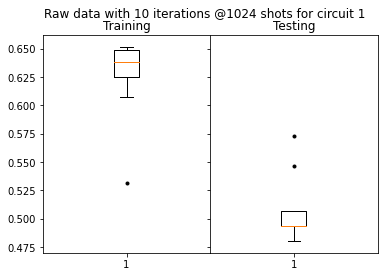

None

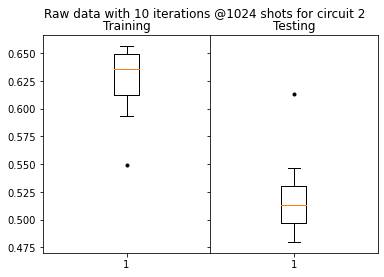

None

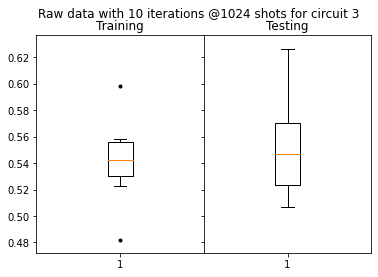

None

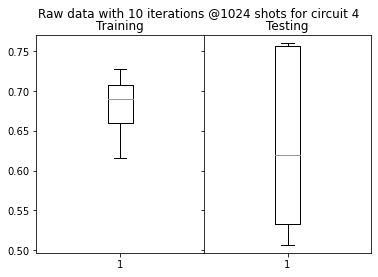

None

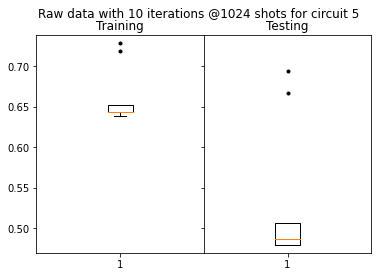

None

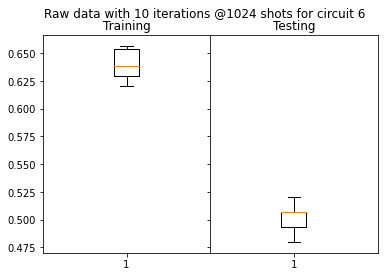

None

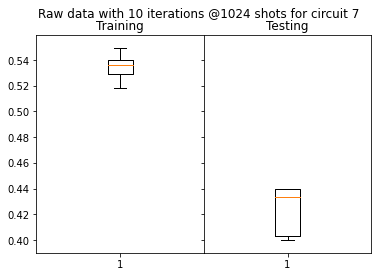

None

In [50]:
for index, run in enumerate(raw_runs):
    title = "Raw data with 10 iterations @" + str(n_shots) + " shots for circuit " + str(index+1)
    plot_boxplots(run, title, index+1, save=True)

In [15]:
normalized_runs = []

display(print("Testing dataset 2"))
for circuit in circuits:
    training_data = []
    testing_data = []
    for i in range(10):
        display(print('run: ' + str(i+1)))
        classifier = get_classifier(circuit.copy())
        x_train,x_test,y_train,y_test = train_test_split(datasets[1], targets, test_size=1-3/4, random_state=69069)
        score_train, score_test = fit_and_score(classifier, x_train, y_train.values, x_test, y_test.values)
        training_data.append(score_train)
        testing_data.append(score_test)
    display(print('Circuit done'))
    normalized_runs.append([training_data, testing_data])

Testing dataset 2


None

run: 1


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.7733333333333333
run: 2


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7733333333333333
run: 3


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7733333333333333
run: 4


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7733333333333333
run: 5


None

Mean Accuracy training: 0.7053571428571429
Mean Accuracy testing: 0.7866666666666666
run: 6


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.76
run: 7


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7866666666666666
run: 8


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.7733333333333333
run: 9


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.76
run: 10


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.7733333333333333
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.76
run: 2


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.7733333333333333
run: 3


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.72
run: 4


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.76
run: 5


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7733333333333333
run: 6


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7466666666666667
run: 7


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.72
run: 8


None

Mean Accuracy training: 0.7098214285714286
Mean Accuracy testing: 0.7733333333333333
run: 9


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.72
run: 10


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.7733333333333333
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7232142857142857
Mean Accuracy testing: 0.7733333333333333
run: 2


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.76
run: 3


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7333333333333333
run: 4


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 5


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 6


None

Mean Accuracy training: 0.7276785714285714
Mean Accuracy testing: 0.7866666666666666
run: 7


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7466666666666667
run: 8


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 9


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 10


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 2


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.72
run: 3


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.72
run: 4


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.7733333333333333
run: 5


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 6


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 7


None

Mean Accuracy training: 0.6651785714285714
Mean Accuracy testing: 0.72
run: 8


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7733333333333333
run: 9


None

Mean Accuracy training: 0.6696428571428571
Mean Accuracy testing: 0.72
run: 10


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.7333333333333333
run: 2


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 3


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7333333333333333
run: 4


None

Mean Accuracy training: 0.6651785714285714
Mean Accuracy testing: 0.72
run: 5


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.7733333333333333
run: 6


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.7333333333333333
run: 7


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7733333333333333
run: 8


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 9


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 10


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
run: 2


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 3


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7733333333333333
run: 4


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7466666666666667
run: 5


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 6


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7466666666666667
run: 7


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.72
run: 8


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.76
run: 9


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.72
run: 10


None

Mean Accuracy training: 0.6741071428571429
Mean Accuracy testing: 0.72
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7633928571428571
Mean Accuracy testing: 0.8133333333333334
run: 2


None

Mean Accuracy training: 0.7633928571428571
Mean Accuracy testing: 0.8133333333333334
run: 3


None

Mean Accuracy training: 0.7544642857142857
Mean Accuracy testing: 0.8
run: 4


None

Mean Accuracy training: 0.7098214285714286
Mean Accuracy testing: 0.8
run: 5


None

Mean Accuracy training: 0.7589285714285714
Mean Accuracy testing: 0.8
run: 6


None

Mean Accuracy training: 0.7723214285714286
Mean Accuracy testing: 0.8
run: 7


None

Mean Accuracy training: 0.7633928571428571
Mean Accuracy testing: 0.8133333333333334
run: 8


None

Mean Accuracy training: 0.7633928571428571
Mean Accuracy testing: 0.8
run: 9


None

Mean Accuracy training: 0.7544642857142857
Mean Accuracy testing: 0.8
run: 10


None

Mean Accuracy training: 0.7633928571428571
Mean Accuracy testing: 0.8133333333333334
Circuit done


None

In [16]:
print(normalized_runs)

[[[0.6741071428571429, 0.6785714285714286, 0.6830357142857143, 0.6830357142857143, 0.7053571428571429, 0.6785714285714286, 0.6964285714285714, 0.6919642857142857, 0.6964285714285714, 0.6919642857142857], [0.7733333333333333, 0.7733333333333333, 0.7733333333333333, 0.7733333333333333, 0.7866666666666666, 0.76, 0.7866666666666666, 0.7733333333333333, 0.76, 0.7733333333333333]], [[0.6919642857142857, 0.7142857142857143, 0.6696428571428571, 0.6875, 0.6964285714285714, 0.6830357142857143, 0.6696428571428571, 0.7098214285714286, 0.6696428571428571, 0.7008928571428571], [0.76, 0.7733333333333333, 0.72, 0.76, 0.7733333333333333, 0.7466666666666667, 0.72, 0.7733333333333333, 0.72, 0.7733333333333333]], [[0.7232142857142857, 0.7008928571428571, 0.6875, 0.6741071428571429, 0.6741071428571429, 0.7276785714285714, 0.6830357142857143, 0.6785714285714286, 0.6741071428571429, 0.6741071428571429], [0.7733333333333333, 0.76, 0.7333333333333333, 0.72, 0.72, 0.7866666666666666, 0.7466666666666667, 0.72, 0

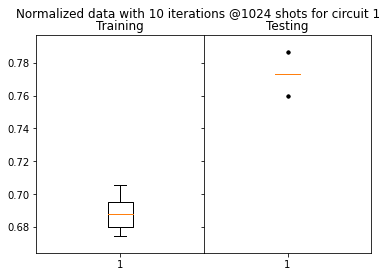

None

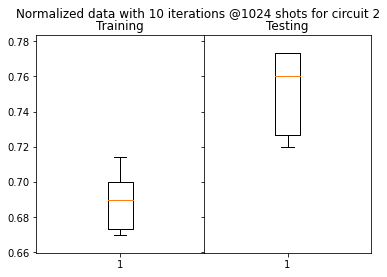

None

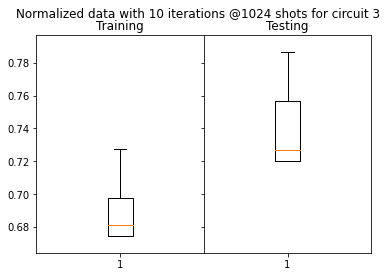

None

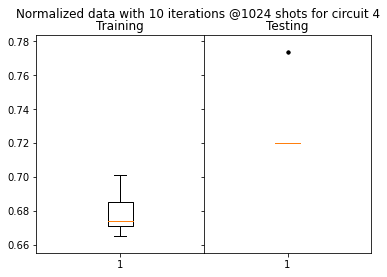

None

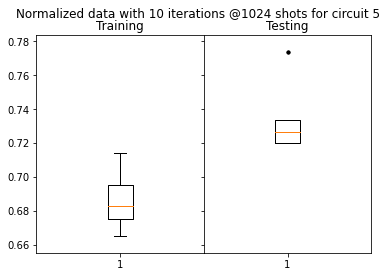

None

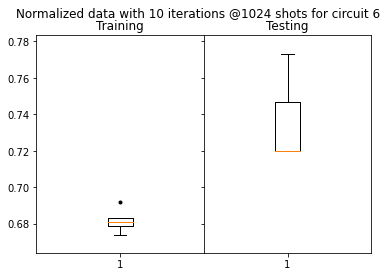

None

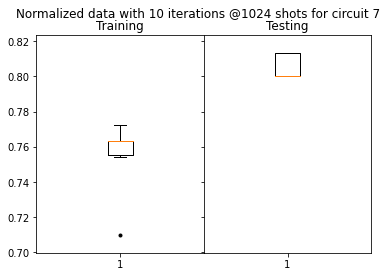

None

In [51]:
for index, run in enumerate(normalized_runs):
    title = "Normalized data with 10 iterations @" + str(n_shots) + " shots for circuit " + str(index+1)
    plot_boxplots(run, title, index+1, save=True)

In [20]:
pified_runs = []


display(print("Testing dataset 3"))
for circuit in circuits:
    training_data = []
    testing_data = []
    for i in range(10):
        display(print('run: ' + str(i+1)))
        classifier = get_classifier(circuit.copy())
        x_train,x_test,y_train,y_test = train_test_split(datasets[2], targets, test_size=1-3/4, random_state=69069)
        score_train, score_test = fit_and_score(classifier, x_train, y_train.values, x_test, y_test.values)
        training_data.append(score_train)
        testing_data.append(score_test)
    display(print('Circuit done'))
    pified_runs.append([training_data, testing_data])

Testing dataset 3


None

run: 1


None

Mean Accuracy training: 0.7232142857142857
Mean Accuracy testing: 0.68
run: 2


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.68
run: 3


None

Mean Accuracy training: 0.6205357142857143
Mean Accuracy testing: 0.64
run: 4


None

Mean Accuracy training: 0.7276785714285714
Mean Accuracy testing: 0.68
run: 5


None

Mean Accuracy training: 0.7232142857142857
Mean Accuracy testing: 0.6666666666666666
run: 6


None

Mean Accuracy training: 0.6383928571428571
Mean Accuracy testing: 0.6533333333333333
run: 7


None

Mean Accuracy training: 0.6339285714285714
Mean Accuracy testing: 0.6666666666666666
run: 8


None

Mean Accuracy training: 0.6294642857142857
Mean Accuracy testing: 0.68
run: 9


None

Mean Accuracy training: 0.6651785714285714
Mean Accuracy testing: 0.68
run: 10


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.5066666666666667
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6294642857142857
Mean Accuracy testing: 0.6533333333333333
run: 2


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.7066666666666667
run: 3


None

Mean Accuracy training: 0.6026785714285714
Mean Accuracy testing: 0.64
run: 4


None

Mean Accuracy training: 0.6116071428571429
Mean Accuracy testing: 0.6533333333333333
run: 5


None

Mean Accuracy training: 0.6071428571428571
Mean Accuracy testing: 0.6533333333333333
run: 6


None

Mean Accuracy training: 0.6026785714285714
Mean Accuracy testing: 0.5733333333333334
run: 7


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.68
run: 8


None

Mean Accuracy training: 0.71875
Mean Accuracy testing: 0.6666666666666666
run: 9


None

Mean Accuracy training: 0.71875
Mean Accuracy testing: 0.68
run: 10


None

Mean Accuracy training: 0.7098214285714286
Mean Accuracy testing: 0.6666666666666666
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6205357142857143
Mean Accuracy testing: 0.6666666666666666
run: 2


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.7066666666666667
run: 3


None

Mean Accuracy training: 0.6026785714285714
Mean Accuracy testing: 0.6266666666666667
run: 4


None

Mean Accuracy training: 0.625
Mean Accuracy testing: 0.6666666666666666
run: 5


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.64
run: 6


None

Mean Accuracy training: 0.6116071428571429
Mean Accuracy testing: 0.64
run: 7


None

Mean Accuracy training: 0.6205357142857143
Mean Accuracy testing: 0.6533333333333333
run: 8


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.6266666666666667
run: 9


None

Mean Accuracy training: 0.6205357142857143
Mean Accuracy testing: 0.64
run: 10


None

Mean Accuracy training: 0.6160714285714286
Mean Accuracy testing: 0.6533333333333333
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.7066666666666667
run: 2


None

Mean Accuracy training: 0.7544642857142857
Mean Accuracy testing: 0.7466666666666667
run: 3


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.68
run: 4


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.8
run: 5


None

Mean Accuracy training: 0.6116071428571429
Mean Accuracy testing: 0.6666666666666666
run: 6


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.76
run: 7


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.72
run: 8


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.6933333333333334
run: 9


None

Mean Accuracy training: 0.7410714285714286
Mean Accuracy testing: 0.7733333333333333
run: 10


None

Mean Accuracy training: 0.75
Mean Accuracy testing: 0.68
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.72
run: 2


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7066666666666667
run: 3


None

Mean Accuracy training: 0.6785714285714286
Mean Accuracy testing: 0.72
run: 4


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7066666666666667
run: 5


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.7066666666666667
run: 6


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.7066666666666667
run: 7


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.72
run: 8


None

Mean Accuracy training: 0.6830357142857143
Mean Accuracy testing: 0.72
run: 9


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.6933333333333334
run: 10


None

Mean Accuracy training: 0.6875
Mean Accuracy testing: 0.7066666666666667
Circuit done


None

run: 1


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.6933333333333334
run: 2


None

Mean Accuracy training: 0.7053571428571429
Mean Accuracy testing: 0.6933333333333334
run: 3


None

Mean Accuracy training: 0.7321428571428571
Mean Accuracy testing: 0.6533333333333333
run: 4


None

Mean Accuracy training: 0.7098214285714286
Mean Accuracy testing: 0.6933333333333334
run: 5


None

Mean Accuracy training: 0.7142857142857143
Mean Accuracy testing: 0.7066666666666667
run: 6


None

Mean Accuracy training: 0.6919642857142857
Mean Accuracy testing: 0.64
run: 7


None

Mean Accuracy training: 0.7008928571428571
Mean Accuracy testing: 0.6933333333333334
run: 8


None

Mean Accuracy training: 0.7276785714285714
Mean Accuracy testing: 0.7066666666666667
run: 9


None

Mean Accuracy training: 0.6964285714285714
Mean Accuracy testing: 0.68
run: 10


None

Mean Accuracy training: 0.7053571428571429
Mean Accuracy testing: 0.6666666666666666
Circuit done


None

run: 1


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.5066666666666667
run: 2


None

Mean Accuracy training: 0.6607142857142857
Mean Accuracy testing: 0.5066666666666667
run: 3


None

Mean Accuracy training: 0.6428571428571429
Mean Accuracy testing: 0.52
run: 4


None

Mean Accuracy training: 0.6651785714285714
Mean Accuracy testing: 0.52
run: 5


None

Mean Accuracy training: 0.6517857142857143
Mean Accuracy testing: 0.52
run: 6


None

Mean Accuracy training: 0.6473214285714286
Mean Accuracy testing: 0.5066666666666667
run: 7


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.5066666666666667
run: 8


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.5066666666666667
run: 9


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.5066666666666667
run: 10


None

Mean Accuracy training: 0.65625
Mean Accuracy testing: 0.5066666666666667
Circuit done


None

In [21]:
print(pified_runs)

[[[0.7232142857142857, 0.7410714285714286, 0.6205357142857143, 0.7276785714285714, 0.7232142857142857, 0.6383928571428571, 0.6339285714285714, 0.6294642857142857, 0.6651785714285714, 0.6160714285714286], [0.68, 0.68, 0.64, 0.68, 0.6666666666666666, 0.6533333333333333, 0.6666666666666666, 0.68, 0.68, 0.5066666666666667]], [[0.6294642857142857, 0.7321428571428571, 0.6026785714285714, 0.6116071428571429, 0.6071428571428571, 0.6026785714285714, 0.7321428571428571, 0.71875, 0.71875, 0.7098214285714286], [0.6533333333333333, 0.7066666666666667, 0.64, 0.6533333333333333, 0.6533333333333333, 0.5733333333333334, 0.68, 0.6666666666666666, 0.68, 0.6666666666666666]], [[0.6205357142857143, 0.6607142857142857, 0.6026785714285714, 0.625, 0.6160714285714286, 0.6116071428571429, 0.6205357142857143, 0.6160714285714286, 0.6205357142857143, 0.6160714285714286], [0.6666666666666666, 0.7066666666666667, 0.6266666666666667, 0.6666666666666666, 0.64, 0.64, 0.6533333333333333, 0.6266666666666667, 0.64, 0.6533

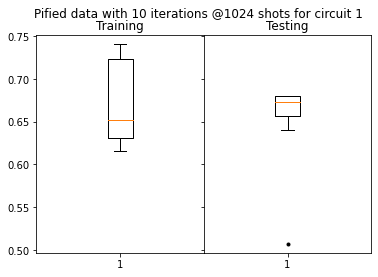

None

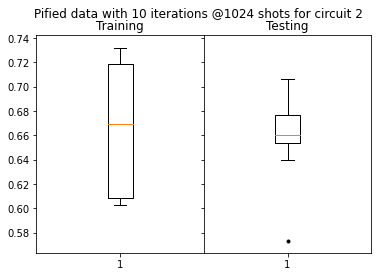

None

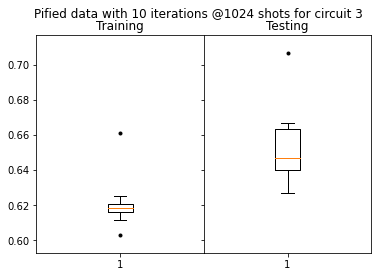

None

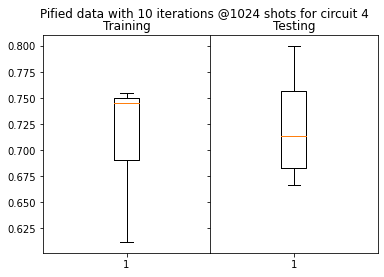

None

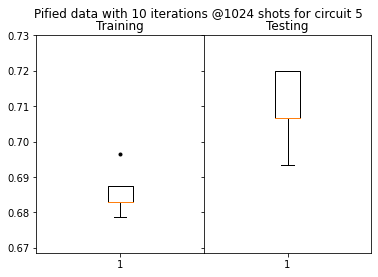

None

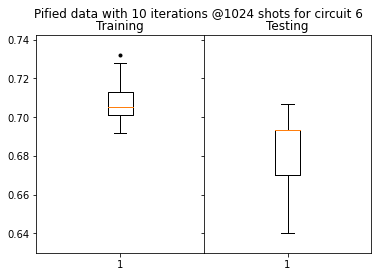

None

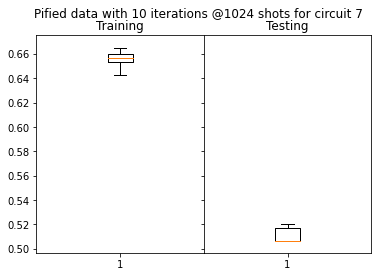

None

In [52]:
for index, run in enumerate(pified_runs):
    title = "Pified data with 10 iterations @" + str(n_shots) + " shots for circuit " + str(index+1)
    plot_boxplots(run, title, index+1, save=True)

In [41]:
#Save all training measurments
with open(training_measurments_path + '/raw_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';',)
    writer.writerow(['circuit', 'type', 'accuracy'])
    for index, circuit in enumerate(raw_runs):
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Training'], run))
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Testing'], run))

#Save all training measurments
with open(training_measurments_path + '/normalized_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';',)
    writer.writerow(['circuit', 'type', 'accuracy'])
    for index, circuit in enumerate(normalized_runs):
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Training'], run))
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Testing'], run))

#Save all training measurments
with open(training_measurments_path + '/pified_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';',)
    writer.writerow(['circuit', 'type', 'accuracy'])
    for index, circuit in enumerate(pified_runs):
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Training'], run))
        for jndex, run in enumerate(circuit[0]):
            writer.writerow(np.append([index+1, 'Testing'], run))